In [2]:
!pip -V

pip 23.3.1 from /root/feature-map-experiments/.cenv/lib/python3.10/site-packages/pip (python 3.10)


# .init

In [3]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [4]:
import os
import sys
from pathlib import Path
workspace_dir = Path.cwd()
if not (workspace_dir / '.git').exists():
    workspace_dir = workspace_dir.parent


module_path = str(workspace_dir.resolve()) # os.path.abspath(os.path.join('..'))
print(f'workspace dir: {module_path}')

# Fixes a periodic issue with locating local packages.
if module_path not in sys.path:
    sys.path.append(module_path)

workspace dir: /root/feature-map-experiments


In [5]:
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np

In [6]:
# import openslide
slides_dir = workspace_dir / 'WSI'
# slide_path = slides_dir / 'C-16-098.svs'

wsi_file_name = 'C-17-036-2021-07-15_215134.ndpi'
slide_path = slides_dir / wsi_file_name

print(f'{slide_path}')


/root/feature-map-experiments/WSI/C-17-036-2021-07-15_215134.ndpi


In [7]:
slide_path.suffix[1:]

'ndpi'

In [8]:
from fmc.file_cache import CachcedFileIndex, OpenSlideWSIDriver

index = CachcedFileIndex(index_root=workspace_dir/'.indexes')

wsi_driver = OpenSlideWSIDriver(file_index=index, original_files_path=slides_dir)
wsi_driver.save_metadata(wsi_file_name)

# Extract patches

In [19]:
wsi_driver.generate_patches(wsi_file_name)

width=134400, height=64512, cols: 150 rows: 72 step_x=896, step_y=896 self.basic_slide_magnification=2
Total: 1000, Saved: 1000, blank: 0
Total: 2000, Saved: 2000, blank: 0
Total: 3000, Saved: 3000, blank: 0
Total: 4000, Saved: 4000, blank: 0
Total: 5000, Saved: 5000, blank: 0
Total: 6000, Saved: 6000, blank: 0
Total: 7000, Saved: 7000, blank: 0
Total: 8000, Saved: 8000, blank: 0
Total: 9000, Saved: 9000, blank: 0
Total: 10000, Saved: 10000, blank: 0
Total: 10800, Saved: 10800, blank: 0


In [9]:
files_list = list((index.get_wsi_stuff_path(wsi_file_name) / 'original').glob('*.*'))

In [10]:
index.get_wsi_stuff_path(wsi_file_name) / 'original'

PosixPath('/root/feature-map-experiments/.indexes/C-17-036-2021-07-15_215134__ndpi/original')

In [11]:

import random

from featup.util import pca, remove_axes
from pytorch_lightning import seed_everything

random.seed(0)
seed_everything(0)

Seed set to 0


0

In [12]:

random_files = random.sample(files_list, 2000)


In [13]:
from fmc.image_utils import detect_blank_patch
threshold = 11.
significant_patches = []
for i, patch_file in enumerate(random_files):
    patch = np.array(Image.open(patch_file).convert('RGB'))
    mean, std_dev, is_blank = detect_blank_patch(patch, threshold=threshold)
    if is_blank:
        print(f'excluded {i}: {mean=} {std_dev=}')
    else:
        significant_patches.append(patch)

significant_patches = np.array(significant_patches)
len(significant_patches)

excluded 0: mean=-0.0011559311224489796 std_dev=1.2871390679137087
excluded 1: mean=-0.00023915816326530612 std_dev=0.719844402083906
excluded 2: mean=-0.0014548788265306121 std_dev=3.5011070526030452
excluded 3: mean=-0.0006975446428571428 std_dev=1.3413598194433831
excluded 4: mean=-1.992984693877551e-05 std_dev=0.6246012755585213
excluded 5: mean=5.978954081632653e-05 std_dev=0.597997692343089
excluded 6: mean=-1.992984693877551e-05 std_dev=0.7931994311728956
excluded 7: mean=9.964923469387754e-05 std_dev=3.6854591580468306
excluded 8: mean=-3.985969387755102e-05 std_dev=0.6306820780831547
excluded 9: mean=5.978954081632653e-05 std_dev=5.4107492776093125
excluded 10: mean=-0.00033880739795918367 std_dev=0.9344656916291769
excluded 11: mean=1.992984693877551e-05 std_dev=4.648311956974026
excluded 12: mean=3.985969387755102e-05 std_dev=0.631092750422388
excluded 13: mean=-0.009646045918367346 std_dev=4.462801832211919
excluded 14: mean=0.001175860969387755 std_dev=1.7983422393841004
e

208

In [14]:
significant_patches = significant_patches[:150]

In [15]:
significant_patches.shape

(150, 224, 224, 3)

In [16]:
import torch
import torchvision.transforms as T

from fmc.segmenter import init_upsampler, transform, mass_upsample, save_indexes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
upsampler = init_upsampler(device)

lr_feats_list, hr_feats_list = mass_upsample(upsampler, significant_patches, device=device, batch_size=24)

Using cache found in /root/.cache/torch/hub/mhamilton723_FeatUp_main
/root/feature-map-experiments/.cenv/lib/python3.10/site-packages/featup/featurizers/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/feature-map-experiments/.cenv/lib/python3.10/site-packages/featup/featurizers/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/feature-map-experiments/.cenv/lib/python3.10/site-packages/featup/featurizers/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/h

image_tensors.shape=torch.Size([150, 3, 224, 224])


/root/feature-map-experiments/.cenv/lib/python3.10/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1704987394225/work/aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


lr_feats_list.shape=torch.Size([150, 384, 16, 16])  hr_feats_list.shape=torch.Size([150, 384, 256, 256])


In [17]:
[hr_feats_pca, lr_feats_pca], fit_pca = pca([hr_feats_list, lr_feats_list], fit_pca=None, max_samples=None)

# [hr_feats_pca, lr_feats_pca], fit_pca = pca([hr_feats_list, lr_feats_list], fit_pca=fit_pca)
# print(f'{hr_feats_pca.shape=}')


hr_feats_pca_arr = [p.permute(1, 2, 0).detach().cpu() for p in hr_feats_pca]

pca: x.shape=torch.Size([19660800, 384])


In [39]:
hr_feats_pca_arr[0].shape

torch.Size([256, 256, 3])

In [40]:
hr_feats_pca[0].shape

torch.Size([3, 256, 256])

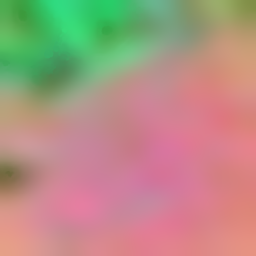

In [48]:
import torchvision.transforms as transforms

transforms.ToPILImage('RGB')(hr_feats_pca[1])

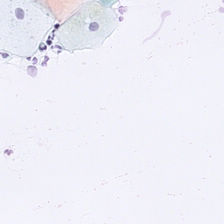

In [49]:
import torchvision.transforms as transforms
transforms.ToPILImage('RGB')(significant_patches[1])

In [32]:
import pickle

with open("pca_model.pkl", "wb") as f:
    pickle.dump(fit_pca, f)

In [42]:
files_list[0].name

'0_0.png'

In [52]:


def pca_process_file_list(upsampler, pca, index, wsi_file_name, files_list, batch_size=24):
    pca_index = index.get_wsi_stuff_path(wsi_file_name) / 'pca'
    pca_index.mkdir(parents=True, exist_ok=True)

    for i in range(0, len(files_list), batch_size):
        batch = files_list[i:i+batch_size]
        image_tensors = [transform(Image.open(f).convert('RGB')) for f in batch]
        image_tensors = torch.stack(image_tensors).to(device)
        with torch.no_grad():
            hr_feats_list = upsampler(image_tensors).cpu()
            # lr_feats_list = upsampler.model(image_tensors).cpu()
        torch.cuda.empty_cache()
        [hr_feats_pca], _ = pca([hr_feats_list], fit_pca=fit_pca)

        for f, hr_f in zip(batch, hr_feats_pca):
            image = transforms.ToPILImage('RGB')(hr_f)
            
            image.save(pca_index / f.name)    

        if i % (batch_size*4) == 0:
            print(f'{i=} files processed')


pca_process_file_list(upsampler, pca, index, wsi_file_name, files_list)


pca: x.shape=torch.Size([1572864, 384])
i=0 files processed
pca: x.shape=torch.Size([1572864, 384])
pca: x.shape=torch.Size([1572864, 384])
pca: x.shape=torch.Size([1572864, 384])
pca: x.shape=torch.Size([1572864, 384])
i=96 files processed
pca: x.shape=torch.Size([1572864, 384])
pca: x.shape=torch.Size([1572864, 384])
pca: x.shape=torch.Size([1572864, 384])
pca: x.shape=torch.Size([1572864, 384])
i=192 files processed
pca: x.shape=torch.Size([1572864, 384])
pca: x.shape=torch.Size([1572864, 384])
pca: x.shape=torch.Size([1572864, 384])
pca: x.shape=torch.Size([1572864, 384])
i=288 files processed
pca: x.shape=torch.Size([1572864, 384])
pca: x.shape=torch.Size([1572864, 384])
pca: x.shape=torch.Size([1572864, 384])
pca: x.shape=torch.Size([1572864, 384])
i=384 files processed
pca: x.shape=torch.Size([1572864, 384])
pca: x.shape=torch.Size([1572864, 384])
pca: x.shape=torch.Size([1572864, 384])
pca: x.shape=torch.Size([1572864, 384])
i=480 files processed
pca: x.shape=torch.Size([157286

In [58]:
hr_feats_pca_arr[0].shape

torch.Size([256, 256, 3])

In [59]:
from fmc.segmenter import kmeans_color_quantization

hr_feats_pca_flat = np.stack(hr_feats_pca_arr).reshape(-1, 3)
print(f'{hr_feats_pca_flat.shape=}')
kmeans, centers = kmeans_color_quantization(hr_feats_pca_flat, 15)

hr_feats_pca_flat=array([[0.26900798, 0.73636335, 0.24910542],
       [0.26902658, 0.736441  , 0.24927557],
       [0.26908728, 0.7357021 , 0.2491861 ],
       ...,
       [0.7888945 , 0.6016531 , 0.4910399 ],
       [0.78888386, 0.6019007 , 0.49111187],
       [0.7888855 , 0.6020599 , 0.49115795]], dtype=float32)


In [61]:
with open("kmeans_model.pkl", "wb") as f:
    pickle.dump(kmeans, f)

In [ ]:
def cluster_file_list(upsampler, pca, index, wsi_file_name, files_list, batch_size=24):
    pca_index = index.get_wsi_stuff_path(wsi_file_name) / 'pca'
    pca_index.mkdir(parents=True, exist_ok=True)

    for i in range(0, len(files_list), batch_size):
        batch = files_list[i:i+batch_size]
        image_tensors = [transform(Image.open(f).convert('RGB')) for f in batch]
        image_tensors = torch.stack(image_tensors).to(device)
        with torch.no_grad():
            hr_feats_list = upsampler(image_tensors).cpu()
            # lr_feats_list = upsampler.model(image_tensors).cpu()
        torch.cuda.empty_cache()
        [hr_feats_pca], _ = pca([hr_feats_list], fit_pca=fit_pca)

        for f, hr_f in zip(batch, hr_feats_pca):
            image = transforms.ToPILImage('RGB')(hr_f)
            
            image.save(pca_index / f.name)    

        if i % (batch_size*4) == 0:
            print(f'{i=} files processed')


pca_process_file_list(upsampler, pca, index, wsi_file_name, files_list)

In [24]:

from pathlib import Path
from PIL import Image

def combine_patches(index_root, wsi_file_name, method, start, magnification, patch_size):
    wsi_stuff_path = index_root / wsi_file_name
    method_index_path = wsi_stuff_path / method

    x, y = start
    patch_width, patch_height = patch_size

    new_magnified_image = Image.new('RGB', (patch_width, patch_height), color=(241, 241, 249))

    for pyi in range(0, magnification, 1):
        for pxj in range(0, magnification, 1): 
            patch_file = method_index_path / f'{x+pxj*patch_width}_{y+pyi*patch_height}.png'
            print(f'[{pxj}, {pyi}]: ({patch_file}) ')
            patch = Image.open(patch_file)
            patch = patch.resize((patch_width // magnification, patch_height // magnification), resample=Image.LANCZOS)
            new_magnified_image.paste(patch, (pxj*patch_width // magnification, pyi*patch_height // magnification))

    return new_magnified_image



[0, 0]: (/root/feature-map-experiments/.indexes/C-17-036-2021-07-15_215134__ndpi/original/4480_6720.png) 
[1, 0]: (/root/feature-map-experiments/.indexes/C-17-036-2021-07-15_215134__ndpi/original/4704_6720.png) 
[2, 0]: (/root/feature-map-experiments/.indexes/C-17-036-2021-07-15_215134__ndpi/original/4928_6720.png) 
[0, 1]: (/root/feature-map-experiments/.indexes/C-17-036-2021-07-15_215134__ndpi/original/4480_6944.png) 
[1, 1]: (/root/feature-map-experiments/.indexes/C-17-036-2021-07-15_215134__ndpi/original/4704_6944.png) 
[2, 1]: (/root/feature-map-experiments/.indexes/C-17-036-2021-07-15_215134__ndpi/original/4928_6944.png) 
[0, 2]: (/root/feature-map-experiments/.indexes/C-17-036-2021-07-15_215134__ndpi/original/4480_7168.png) 
[1, 2]: (/root/feature-map-experiments/.indexes/C-17-036-2021-07-15_215134__ndpi/original/4704_7168.png) 
[2, 2]: (/root/feature-map-experiments/.indexes/C-17-036-2021-07-15_215134__ndpi/original/4928_7168.png) 


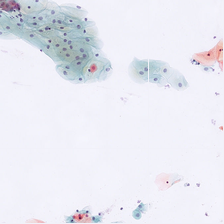

In [36]:
start = 20 * 224, 30 * 224

combine_patches(Path('/root/feature-map-experiments/.indexes'), 'C-17-036-2021-07-15_215134__ndpi', 'original', start, 3, (224, 224))

In [31]:
start


(6722912, 54880)

In [15]:
54880/224

245.0